# Data importation

In [1]:
import random
import numpy as np
from sklearn import svm
from sklearn.metrics.pairwise import linear_kernel
from sklearn import preprocessing
import nltk
import csv
import pandas as pd
from nltk.stem import SnowballStemmer
import matplotlib.pyplot as plt
import networkx as nx
import re

%matplotlib inline

In [2]:
info = pd.read_csv(
    "node_information.csv", 
    header= None, 
    names=["Id", "year", "title", "authors", "journal", "abstract"],
    sep=",",
    index_col = 0
)

In [3]:
X_train = pd.read_csv("training_set.txt", sep=" ", header=None)
X_test = pd.read_csv("testing_set.txt", sep=" ", header=None)
y_train = X_train[2]
X_train.drop([2], axis = 1, inplace = True)

print info.shape, X_train.shape, X_test.shape

(27770, 5) (615512, 2) (32648, 2)


In [4]:
######################
### FOR VALIDATION ###
######################


#####################
#from sklearn.cross_validation import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2)
#####################

#####################
small_portion_to_train = 50000
small_portion_to_test  = 5000
#X_train = X_train[:small_portion_to_train]
#y_train = y_train[:small_portion_to_train]

#X_test  = X_test[:small_portion_to_test]
#y_test = y_test[:small_portion_to_test]
#####################

# Feature Preprocess

- list_authors is the list of authors in the papers
- list_universities is the list where the authors are from

In [5]:
def universities_to_keep(authors, universities):
    while('(' in authors and ')' in authors):
        universities.append( authors[authors.find('(')+1 : authors.find(')')] )
        authors = authors[: authors.find('(')] + authors[ authors.find(')')+1 : ]
            
    if '(' in authors:
        universities.append( authors[authors.find('(')+1 : ])
        authors = authors[: authors.find('(')]
    
    return authors, universities


def name_to_keep(author):
    if len(author.split(' ')) <= 1:
        return author
    
    while( author[0] == ' ' and len(author) > 0):
        author = author[1:]
    while( author[-1] == ' ' and len(author) > 0):
        author = author[:-1]
    
    author = author.replace('.', '. ')
    author = author.replace('.  ', '. ')
    name_to_keep = author.split(' ')[0][0] + '. ' + author.split(' ')[-1]

    return name_to_keep

# Transform concatenated names of authors to a list of authors 
list_authors = []
list_universities = []

info['authors'] = info['authors'].replace(np.nan, 'missing')
for authors in info['authors']:
    if authors != 'missing':
        ### split the different authors
        authors = authors.lower()
        
        ### Find the universities included in the name
        universities = []
        authors, universities = universities_to_keep(authors, universities)
        
        ### Split the authors
        authors = re.split(',|&', authors)
        
        ### For each author, check if university, and store it. Also, keep just the names (To be improved)
        authors_in_article = []      
        for author in authors:
            if author != ' ':
                authors_in_article.append(name_to_keep(author))
            
        list_universities.append(universities)
        list_authors.append(authors_in_article)
    else:
        list_universities.append(['missing'])
        list_authors.append(['missing'])   
        
info['authors'] = list_authors
info['universities'] = list_universities

# Topologic features

In [6]:
def make_graph(X_train, y_train, X_test):
    X_train = pd.concat([X_train, y_train], axis = 1)
    X_train = X_train.values
    G = nx.DiGraph()
    for i in range(X_train.shape[0]):
        source = X_train[i,0]
        target = X_train[i,1]
        G.add_node(source)
        G.add_node(target)
        if X_train[i,2] == 1:
            G.add_edge(source,target)
            
    X_test = X_test.values
    for i in range(X_test.shape[0]):
        source = X_test[i,0]
        target = X_test[i,1]
        G.add_node(source)
        G.add_node(target)
        
    return G  

In [7]:
G = make_graph(X_train, y_train, X_test)  

In [8]:
%%time
from create_topologic_features import create_topologic_features
X_train = create_topologic_features(X_train, G)
X_test = create_topologic_features(X_test, G)

CPU times: user 4min 7s, sys: 2.93 s, total: 4min 10s
Wall time: 4min 9s


# Semantic features
- Cosine similarity within the titles as tf-idf
- Cosine similarity within the abstracts as tf-idf
- Cosine similarity within the titles as word2vec
- Cosine similarity within the abstracts as word2vec

### To try
- Difference cosine similarities?
- Keep the stopwords or not?
- Stemmise the words of not?

# Attribute features

- Difference in publication year
- Number of common authors
- Self-citation
- Same journal
- Number of times "to" cited (Attraction of the "to" paper)

### To try
- Number of times each author of "to" cited [Sum of these number of times] ?
- Number of times each journal cited?
- Number of same university??

In [9]:
%%time
from create_attribute_features import create_attribute_features
X_train = create_attribute_features(X_train,info)
X_test = create_attribute_features(X_test,info)

CPU times: user 11min 38s, sys: 3.5 s, total: 11min 41s
Wall time: 11min 59s


# Author Graph Features

In [10]:
%%time 
from author_graph import make_graph_authors, create_topologic_features_authors

G_authors = make_graph_authors(X_train, y_train, info)
X_train = create_topologic_features_authors(X_train, G_authors, info, betweeness = True, common_neigh_and_jacc = True, inlinks = True)
X_test = create_topologic_features_authors(X_test, G_authors, info,  betweeness = True, common_neigh_and_jacc = True, inlinks = True)

CPU times: user 37min 13s, sys: 7.85 s, total: 37min 20s
Wall time: 38min 9s


In [11]:
X_train.head()

,0,1,Betweeness centrality,Number common neighbours,Jaccard coefficienf,Difference in inlinks coefficient,Number of times to cited,Same cluster,Diff publication,Number same authors,Self citation,Same journal,Authors betweeness,Authors common neighbors,Authors jaccard,Authors max difference in inlinks,Authors sum difference in inlinks,Authors max of times to cited,Authors sum of times to cited,Authors of times to cited
0,9510123,9502114,-0.000216,1,0.058824,5,8,0,0,0,0,1,1.080947,636,0.097952,-5247,-4982,426,161,154.0
1,9707075,9604178,-0.002449,20,0.097087,113,124,1,1,0,0,0,-0.063470,413,0.324430,363,682,1086,758,543.0
2,9312155,9506142,-0.000144,0,0.000000,1,2,0,-2,0,0,0,-0.005749,1,0.023256,14,13,15,15,15.0
3,9911255,302165,0.000216,0,0.000000,-2,2,1,-4,0,0,0,-0.056456,291,0.266728,222,214,667,667,667.0
4,9701033,209076,-0.000612,0,0.000000,-5,2,0,-5,0,0,0,1.116592,134,0.020685,-5393,-5389,19,15,9.5


In [12]:
X_test.head()

,0,1,Betweeness centrality,Number common neighbours,Jaccard coefficienf,Difference in inlinks coefficient,Number of times to cited,Same cluster,Diff publication,Number same authors,Self citation,Same journal,Authors betweeness,Authors common neighbors,Authors jaccard,Authors max difference in inlinks,Authors sum difference in inlinks,Authors max of times to cited,Authors sum of times to cited,Authors of times to cited
0,9807076,9807139,0.001476,0,0.000000,-46,3,1,0,0,0,0,0.069564,424,0.275325,-383,-1352,678,539,339
1,109162,1182,0.009291,24,0.074303,-61,39,1,1,0,0,0,0.082327,302,0.258120,-145,277,719,297,215
2,9702187,9510135,-0.018582,59,0.065338,517,726,1,2,0,0,1,-0.819018,2465,0.374677,3183,2003,5408,5408,5408
3,111048,110115,-0.000504,21,0.221053,5,16,1,0,0,0,1,-0.070829,358,0.229487,577,1275,1680,872,532
4,9910176,9410073,-0.005150,0,0.000000,143,144,1,5,0,0,0,-0.143498,289,0.135681,1108,3146,3367,1329,1171


# Classifier

In [13]:
def score(pred, real):
    tot = 0
    for i, val in enumerate(real):
        if pred[i] == val:
            tot += 1
    return float(tot)/len(real)

In [14]:
y_train.shape

(615512,)

In [16]:
%%time
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(n_estimators = 600)
gbc.fit(X_train.drop([0,1], axis = 1), y_train)
pred = gbc.predict(X_test.drop([0,1], axis = 1))
#print score(pred, y_test)

CPU times: user 49min 58s, sys: 20.1 s, total: 50min 18s
Wall time: 51min 43s


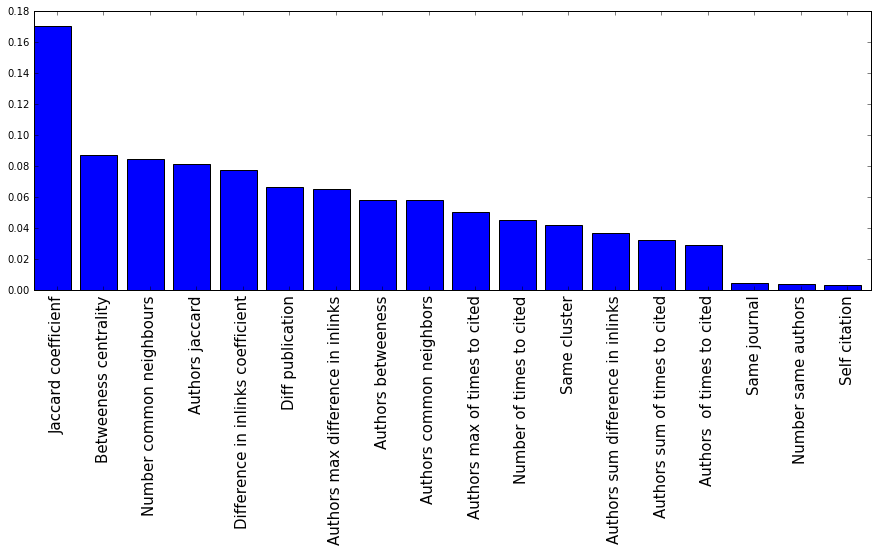

In [17]:
plt.figure(figsize=(15, 5))
X_columns = X_train.drop([0,1], axis = 1).columns
ordering = np.argsort(gbc.feature_importances_)[::-1]

importances = gbc.feature_importances_[ordering]
feature_names = X_columns[ordering]

x = np.arange(len(feature_names))
plt.bar(x, importances)
plt.xticks(x + 0.5, feature_names, rotation=90, fontsize=15);

In [18]:
def make_submission(predicted_label, name = 'submit.csv'):
    submit_d = d = {'id' : pd.Series(np.arange(predicted_label.shape[0]).astype(int)),
                    'category' : pd.Series(predicted_label).astype(int)}
    submit = pd.DataFrame(submit_d, columns=["id","category"])
    submit.to_csv(name,index=False)
    return submit


In [19]:
submit = make_submission(pred)

In [ ]:
submit.shape

In [ ]:
[l for i,l in enumerate(pred)]